In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [18]:
# Read the data
df = pd.read_csv('../player_game_statistics.csv')

In [19]:
# Data Preprocessing for Player classification Prediction
# Convert categorical variables
gender_encoder = LabelEncoder()
country_encoder = LabelEncoder()
game_encoder = LabelEncoder()
level_encoder = LabelEncoder()
df['gender_encoded'] = gender_encoder.fit_transform(df['gender'])
df['country_encoded'] = country_encoder.fit_transform(df['country'])
df['game_encoded'] = game_encoder.fit_transform(df['game_name'])
player_level_encoded = level_encoder.fit_transform(df['player_level'])

# Select features for player classification
features = ['total_games_played', 'total_moves', 'total_wins', 'total_losses','win_ratio', 'total_time_played_minutes', 'gender_encoded', 'country_encoded', 'age', 'game_encoded']

X = df[features]
y = player_level_encoded  # Using player_level as target

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}



Random Forest Results:
Cross-validation scores mean: 0.9988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00        16

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



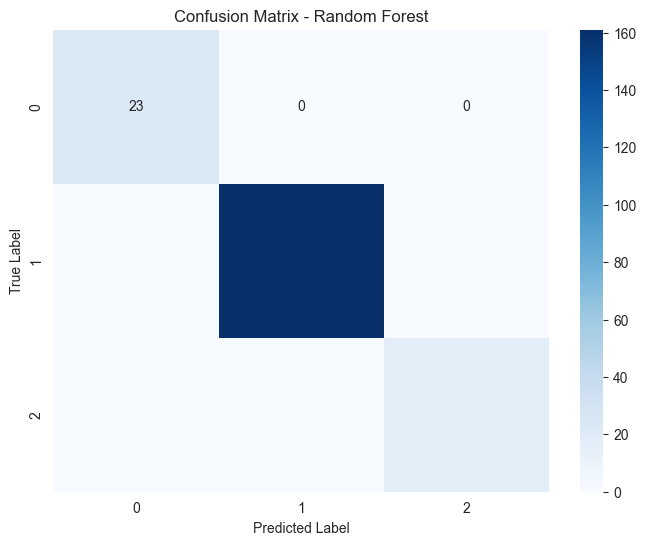


Gradient Boosting Results:
Cross-validation scores mean: 0.9963

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00        16

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



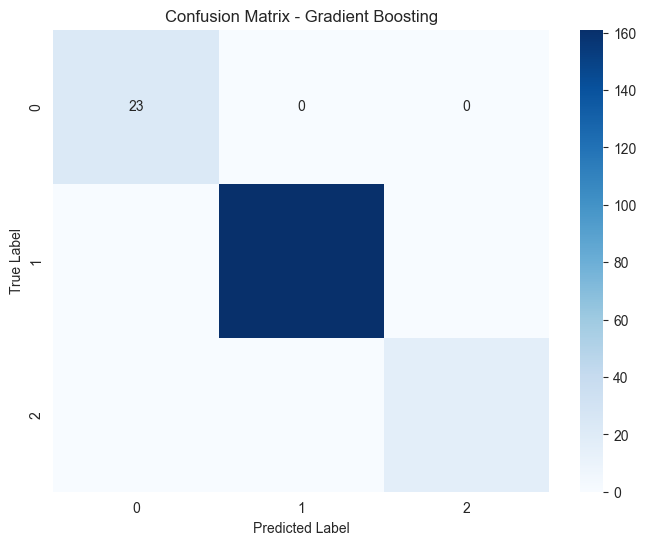


SVM Results:
Cross-validation scores mean: 0.9338

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       0.94      0.99      0.96       161
           2       0.91      0.62      0.74        16

    accuracy                           0.94       200
   macro avg       0.93      0.80      0.85       200
weighted avg       0.93      0.94      0.93       200



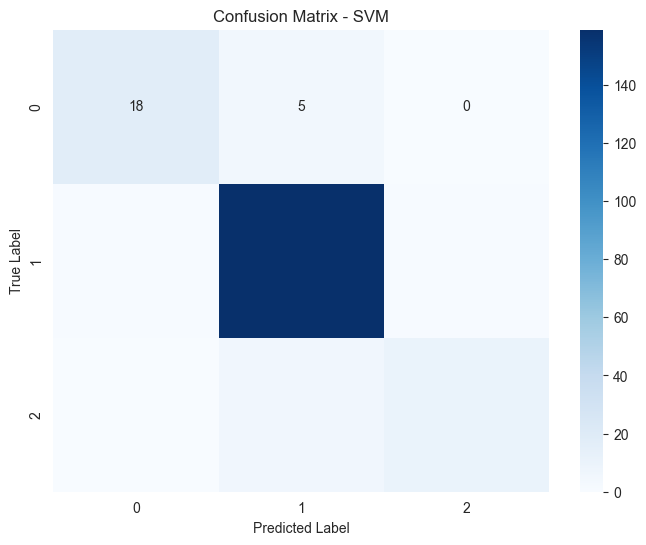


KNN Results:
Cross-validation scores mean: 0.9187

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.89      0.96      0.93       161
           2       0.67      0.25      0.36        16

    accuracy                           0.88       200
   macro avg       0.79      0.64      0.68       200
weighted avg       0.86      0.88      0.86       200



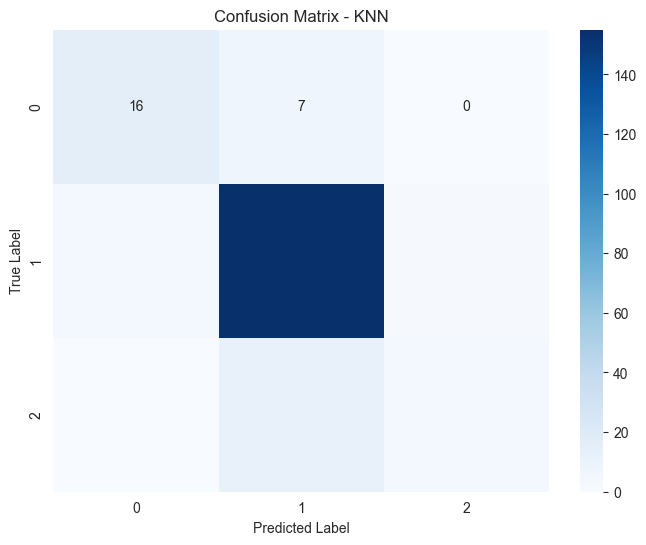

In [23]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Store results
    results[name] = {
        'Classification Report': classification_report(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    results[name]['CV Scores'] = cv_scores
    print(f"\n{name} Results:")
    print(f"Cross-validation scores mean: {cv_scores.mean():.4f}")
    print("\nClassification Report:")
    print(results[name]['Classification Report'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


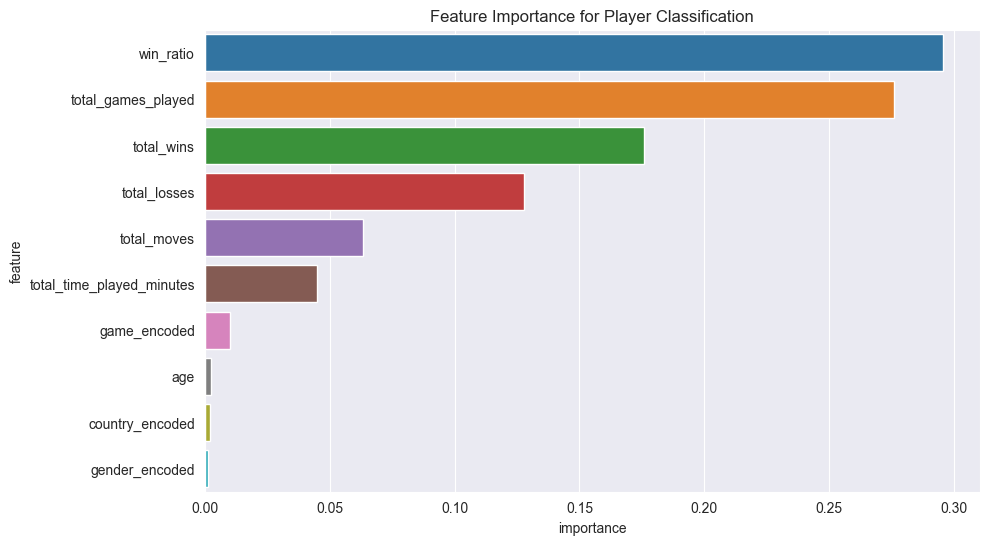

In [24]:
# Feature Importance for Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Player Classification')
plt.show()

In [25]:
# Select the best model
best_model_name = max(results, key=lambda x: np.mean(results[x]['CV Scores']))
best_model = models[best_model_name]
best_cv_score = np.mean(results[best_model_name]['CV Scores'])

print(f"\nBest Model: {best_model_name}")
print(f"Best Cross-validation Score: {best_cv_score:.4f}")


Best Model: Random Forest
Best Cross-validation Score: 0.9988


In [26]:
# Save the best model
with open('../models/player_classification_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('../models/player_classification_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save all encoders
encoder_dict = {
    'gender_encoder': gender_encoder,
    'country_encoder': country_encoder,
    'game_encoder': game_encoder,
    'level_encoder': level_encoder
}

with open('../models/player_classification_encoders.pkl', 'wb') as f:
    pickle.dump(encoder_dict, f)

In [27]:
# Function to load models
def load_player_classification_model():
    with open('../models/player_classification_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('../models/player_classification_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    with open('../models/player_classification_encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)
    
    return model, scaler, encoders

In [35]:
def predict_player_level(data, model, scaler, encoders):
    """
    Predict player level based on gameplay statistics
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the required features
    model: Loaded model
    scaler: Loaded scaler
    encoders: Dictionary of loaded encoders
    
    Returns:
    np.array: Predicted player levels
    """
    try:
        # Preprocess the data
        data_processed = data.copy()
        
        # Encode categorical variables
        data_processed['gender_encoded'] = encoders['gender_encoder'].transform(data_processed['gender'])
        data_processed['country_encoded'] = encoders['country_encoder'].transform(data_processed['country'])
        data_processed['game_encoded'] = encoders['game_encoder'].transform(data_processed['game_name'])
        
        # Calculate win ratio if not provided
        if 'win_ratio' not in data_processed.columns:
            data_processed['win_ratio'] = data_processed['total_wins'] / data_processed['total_games_played']
        
        # Select and order features
        features = ['total_games_played', 'total_moves', 'total_wins', 'total_losses',
                   'win_ratio', 'total_time_played_minutes', 'gender_encoded', 
                   'country_encoded', 'age', 'game_encoded']
        
        X = data_processed[features]
        X_scaled = scaler.transform(X)
        
        # Make predictions
        predictions = model.predict(X_scaled)
        predicted_levels = encoders['level_encoder'].inverse_transform(predictions)
        
        return predicted_levels
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None

# Test with example data
example_data = pd.DataFrame({
    'total_games_played': [4, 123, 130],
    'total_moves': [10, 5765, 6211],
    'total_wins': [1, 39, 96],
    'total_losses': [3, 84, 34],
    'win_ratio': [25.0, 31.71, 73.85],
    'total_time_played_minutes': [100, 3180, 3380],
    'gender': ['Male', 'Male', 'Male'],
    'country': ['USA', 'Brazil', 'China'],
    'game_name': ['chess', 'battleship', 'battleship'],
    'age': [25, 50, 22]
})

# Load model and make predictions
try:
    # Load the model and components
    model, scaler, encoders = load_player_classification_model()
    
    # Make predictions
    predictions = predict_player_level(example_data, model, scaler, encoders)
    
    # Print results with detailed information
    for i, pred in enumerate(predictions):
        print(f"\nPlayer {i+1}:")
        print(f"Games Played: {example_data['total_games_played'].iloc[i]}")
        print(f"Wins/Losses: {example_data['total_wins'].iloc[i]}/{example_data['total_losses'].iloc[i]}")
        print(f"Win Rate: {(example_data['total_wins'].iloc[i] / example_data['total_games_played'].iloc[i]):.2f}")
        print(f"Total Time: {example_data['total_time_played_minutes'].iloc[i]} minutes")
        print(f"Game: {example_data['game_name'].iloc[i]}")
        print(f"Predicted Level: {pred}")
        print("-" * 30)
        
except Exception as e:
    print(f"Error loading model or making predictions: {str(e)}")


Player 1:
Games Played: 4
Wins/Losses: 1/3
Win Rate: 0.25
Total Time: 100 minutes
Game: chess
Predicted Level: novice
------------------------------

Player 2:
Games Played: 123
Wins/Losses: 39/84
Win Rate: 0.32
Total Time: 3180 minutes
Game: battleship
Predicted Level: intermediate
------------------------------

Player 3:
Games Played: 130
Wins/Losses: 96/34
Win Rate: 0.74
Total Time: 3380 minutes
Game: battleship
Predicted Level: expert
------------------------------


In [29]:
# Print available categories
print("Available level:", level_encoder.classes_)
print("Available genders:", gender_encoder.classes_)

Available level: ['expert' 'intermediate' 'novice']
Available genders: ['Female' 'Male' 'Non-Binary']


In [36]:
# Create data for a single player
new_player = pd.DataFrame({
    'total_games_played': [50],
    'total_moves': [750],
    'total_wins': [25],
    'total_losses': [25],
    'total_time_played_minutes': [1000],
    'gender': ['Male'],
    'country': ['USA'],
    'game_name': ['chess'],
    'age': [30]
})

# Load model and predict
model, scaler, encoders = load_player_classification_model()
prediction = predict_player_level(new_player, model, scaler, encoders)

print(f"Predicted player level: {prediction[0]}")

Predicted player level: intermediate
